<a href="https://colab.research.google.com/github/andersonjhones/Analise_de_dados_pandas_DIO/blob/main/analise_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análises COVID-19

## Digital Innovation One

### Adaptado do Prof. Dr. Neylson Crepalde

Analises das séries temporais sobre a contaminação do vírus COVID-19 pelo mundo.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as m
# Importações para formatação de gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 12,7
m.style.use('ggplot')
%matplotlib inline

Agora, vamos importar os dados. É importante já dizer no comando `pd.read_csv` quais são as colunas que serão "parseadas" como datas. O pandas possui métodos robustos para trabalhar com esse tipo de informação.

In [2]:
url = 'https://github.com/neylsoncrepalde/projeto_eda_covid/blob/master/covid_19_data.csv?raw=true'

df = pd.read_csv(url, parse_dates=['ObservationDate', 'Last Update'])
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


Agora, vamos conferir os tipos das variáveis para verificar que as colunas foram corretamente importadas.

In [ ]:
df.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

Nomes de colunas não devem ter letras maiúsculas e nem caracteres especiais. Vamos utilizar uma função para corrigir os nomes das colunas.

In [3]:
import re
def corrige_colunas(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

In [4]:
df.columns = [corrige_colunas(col) for col in df.columns]

In [5]:
df.head()

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


## Análises

Show! Agora vamos começar a investigar as variáveis que temos à disposição. Sabemos que trata-se de séries temporais que estão divididas por estado. Para fazer qualquer análise, portanto, precisamos dividir os nossos dados esse "grão". 

Vamos verificar primeiro quantos estados temos informações para o Brasil.

In [ ]:
df.loc[df.countryregion == 'Brazil']

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
82,83,2020-01-23,NaN,Brazil,2020-01-23 17:00:00,0.0,0.0,0.0
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0


Opa. No caso do Brasil, não temos informação a nível de estado, apenas a nível do país. Ok, então. Vamos verificar como está o comportamento dos casos confirmados no Brasil desde o primeiro caso confirmado, 26 de fevereiro.

## Casos confirmados

In [7]:
brasil = df.loc[(df.countryregion == 'Brazil') & (df.confirmed > 0)]

In [ ]:
px.line(brasil, 'observationdate', 'confirmed', 
        labels={'observationdate':'Data', 'confirmed':'Número de casos confirmados'},
       title='Casos confirmados no Brasil')

## Número de novos casos por dia

In [8]:
# Vamos implementar uma função para fazer a contagem de novos casos
brasil['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else brasil['confirmed'].iloc[x] - brasil['confirmed'].iloc[x-1],
    np.arange(brasil.shape[0])
))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
brasil.novoscasos[brasil.novoscasos<0]

Series([], Name: novoscasos, dtype: float64)

In [ ]:
# Visualizando
px.line(brasil, x='observationdate', y='novoscasos', title='Novos casos por dia',
       labels={'observationdate': 'Data', 'novoscasos': 'Novos casos'})

O número de novos casos parece ser um excelente caso para modelagem. Será que conseguimos predizer quando o número de novos casos vai começar a cair?

## Mortes

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=brasil.observationdate, y=brasil.deaths, name='Mortes', mode='lines+markers',
              line=dict(color='red'))
)
#Edita o layout
fig.update_layout(title='Mortes por COVID-19 no Brasil',
                   xaxis_title='Data',
                   yaxis_title='Número de mortes')
fig.show()

# Taxa de crescimento

Vamos calcular a taxa de crescimento do COVID desde o primeiro caso.

In [ ]:
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    # Se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # Define os valores de presente e passado
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]
    
    # Define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa*100

In [ ]:
cresc_medio = taxa_crescimento(brasil, 'confirmed')
print(f"O crescimento médio do COVID no Brasil no período avaliado foi de {cresc_medio.round(2)}%.")

O crescimento médio do COVID no Brasil no período avaliado foi de 16.27%.


Agora, vamos observar o comportamento da **taxa de crescimento no tempo**. Para isso, vamos definir uma função para calcular a taxa de crescimento diária.

In [ ]:
def taxa_crescimento_diaria(data, variable, data_inicio=None):
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observationdate.max()
    n = (data_fim - data_inicio).days
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1,n+1)
    ))
    return np.array(taxas)*100

In [ ]:
tx_dia = taxa_crescimento_diaria(brasil, 'confirmed')

In [ ]:
tx_dia

array([  0.        ,   0.        , 100.        ,   0.        ,
         0.        ,   0.        , 100.        ,   0.        ,
       225.        ,   0.        ,  53.84615385,  25.        ,
        24.        ,  22.58064516,  36.84210526, 190.38461538,
         0.        ,   7.28476821,  23.45679012,  60.5       ,
        15.88785047,  66.93548387,  27.69726248,  28.75157629,
        51.4201763 ,  24.45019405,  16.78794179,  13.66266133,
        16.87548943,  14.47236181,  14.25226807,   9.01639344,
         7.58928571,  24.8525879 ,  19.57320273,  17.67115272,
        12.58080557,  14.39929329,   7.43243243,   9.26325247,
        15.40169394,  15.22017956,  11.88620903,   8.54521335,
         5.54537122,   7.06807546,   5.57858688,   7.81903542,
        12.10513815,   7.4329096 ,  10.70501233,   8.83557983,
         5.44492335,   5.4043566 ,   5.73350023,   6.21648599,
         9.35157462,   8.00823407,   9.77184834,   6.36504619,
         6.88748019,   8.58316283,   8.80726429,   9.41

In [ ]:
primeiro_dia = brasil.observationdate.loc[brasil.confirmed > 0].min()
px.line(x=pd.date_range(primeiro_dia, brasil.observationdate.max())[1:],
        y=tx_dia, title='Taxa de crescimento de casos confirmados no Brasil',
       labels={'y':'Taxa de crescimento', 'x':'Data'})

# Predições

Vamos construir um modelo de séries temporais para prever os novos casos. Antes analisemos a série temporal.

##Decomposição da série temporal de novos casos de Covid19 no Brasil

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [10]:
novoscasos = brasil.novoscasos
novoscasos.index = brasil.observationdate

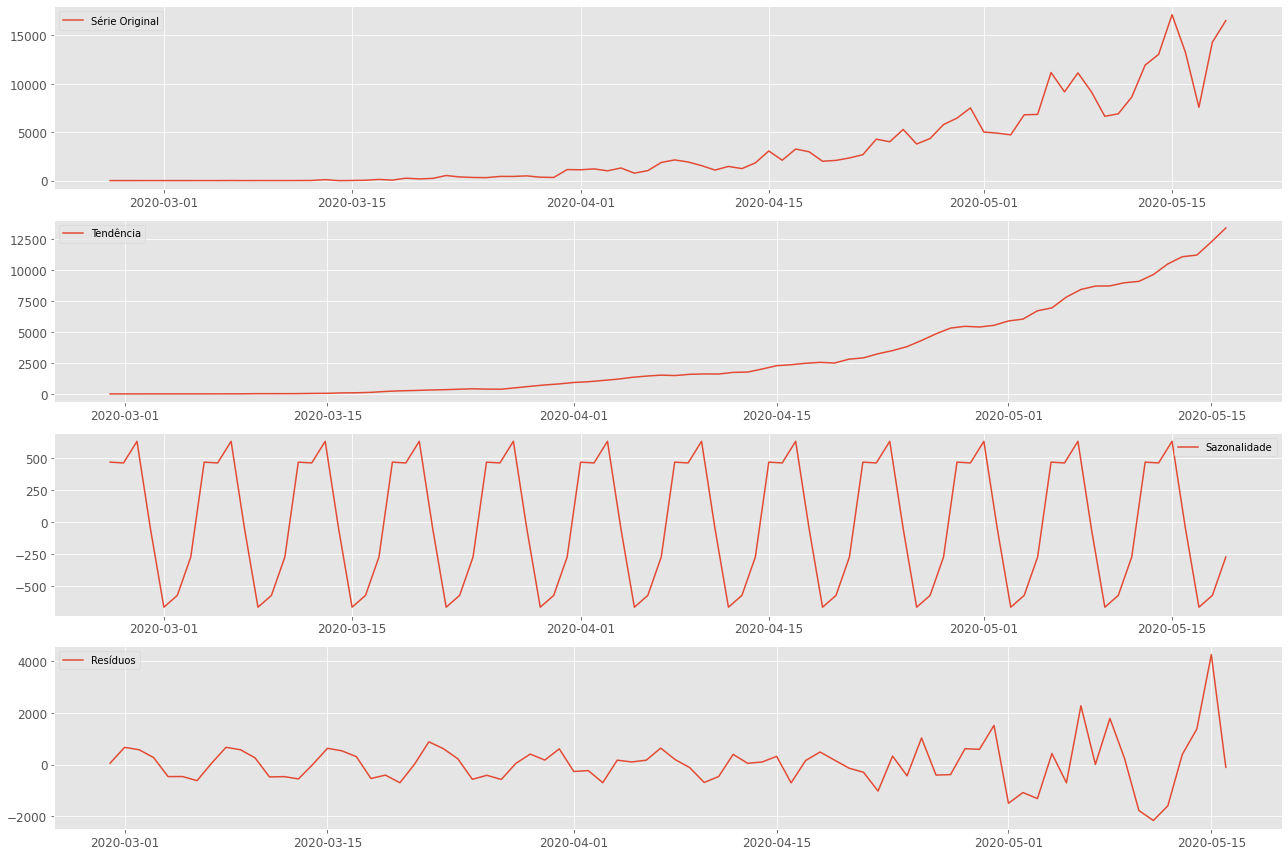

In [ ]:
# Decomposição da série temporal de óleo diesel e óleo combustível
decomposition = seasonal_decompose(novoscasos, period = 7)
rcParams['figure.figsize'] = 18, 12

# Componentes 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(novoscasos, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

##Gráfico que mostra a série origial, sua média móvel e o desvio padrão, além da comprovação que a série não é estacionário, pois tem uma tendência muito forte de alta ao longo dos dios, mas há alguns pontos de mudança do pomportamento da série temporal com apresentação de baixas da contaminação por covid19, pois como vimos na figura da decomposição da série, existe um comportamento sazonal, que foi evidenciado de forma semanal.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Testando a estacionariedade da série através da criação de uma função
def testa_estacionaridade(serie):
    rcParams['figure.figsize'] = 20, 7

    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 7).mean()
    rolstd = serie.rolling(window = 7).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

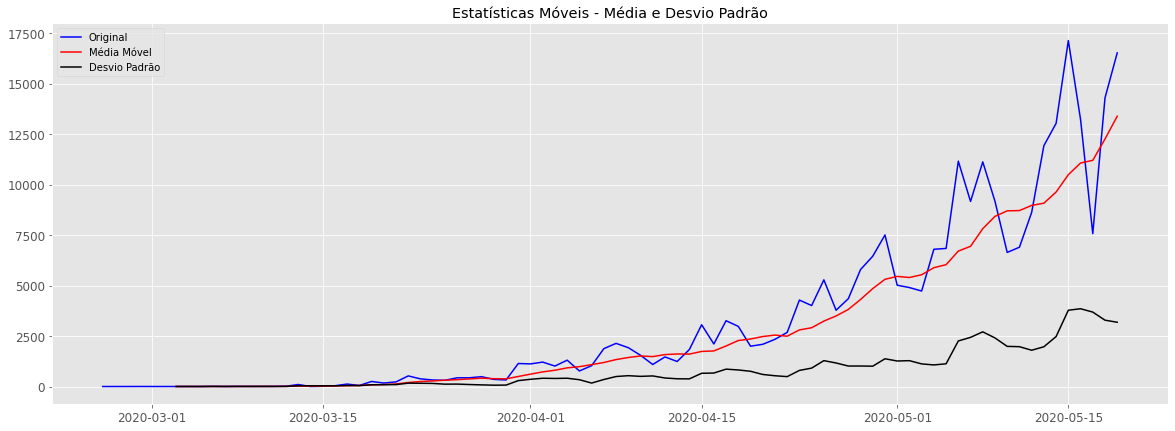


Resultado do Teste Dickey-Fuller:

Estatística do Teste             5.538558
Valor-p                          1.000000
Número de Lags Consideradas     12.000000
Número de Observações Usadas    71.000000
Valor Crítico (1%)              -3.526005
Valor Crítico (5%)              -2.903200
Valor Crítico (10%)             -2.588995
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [ ]:
# Observando se a série é estacionária ou não
testa_estacionaridade(novoscasos)

In [ ]:
novoscasos

observationdate
2020-02-26        0.0
2020-02-27        0.0
2020-02-28        0.0
2020-02-29        1.0
2020-03-01        0.0
               ...   
2020-05-15    17126.0
2020-05-16    13220.0
2020-05-17     7569.0
2020-05-18    14288.0
2020-05-19    16517.0
Name: novoscasos, Length: 84, dtype: float64

## Decompondo a série de confirmados



In [76]:
confirmados = brasil.confirmed
confirmados.index = brasil.observationdate

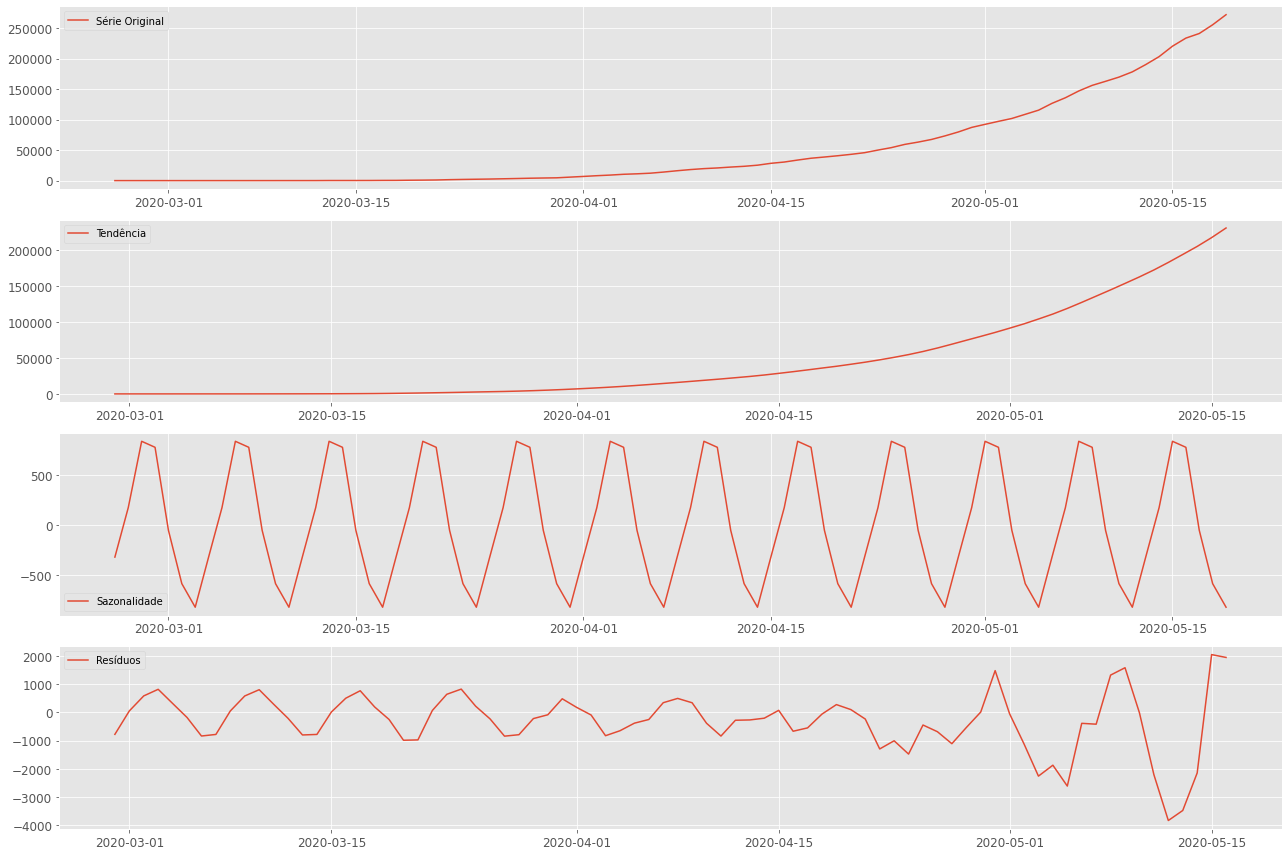

In [ ]:
# Decomposição da série temporal de óleo diesel e óleo combustível
decomposition = seasonal_decompose(confirmados, period = 7)
rcParams['figure.figsize'] = 18, 12

# Componentes 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(confirmados, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

# Predizendo o número de casos confirmados com um AUTO-ARIMA

##Devido há alguns problemas de incompatibilidade de bibliotecas foi preciso desinstalar o numpy, atualizar o pip e depois instalar novamente o numpy

In [ ]:
#!pip install pmdarima

In [92]:
 !pip install -q -U statsmodels
 !pip install -q pmdarima

     |████████████████████████████████| 9.8 MB 28.6 MB/s 
     |████████████████████████████████| 1.8 MB 27.2 MB/s 


In [ ]:
#pip install pyramid-arima

In [ ]:
pip uninstall numpy


Found existing installation: numpy 1.21.6
Uninstalling numpy-1.21.6:
  Would remove:
    /usr/bin/f2py
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.7
    /usr/local/lib/python3.7/dist-packages/numpy-1.21.6.dist-info/*
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libgfortran-2e0d59d6.so.5.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libopenblasp-r0-2d23e62b.3.17.so
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libquadmath-2d0c479f.so.0.0.0
    /usr/local/lib/python3.7/dist-packages/numpy/*
Proceed (y/n)? y
  Successfully uninstalled numpy-1.21.6


In [ ]:
!pip install --upgrade pip
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 29.2 MB/s eta 0:00:00


#Aplicação do modelo arima

In [93]:
from pmdarima.arima import auto_arima

In [94]:
modelo = auto_arima(confirmados)

In [95]:
pd.date_range('2020-05-01', '2020-05-19')

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19'],
              dtype='datetime64[ns]', freq='D')

In [96]:
fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name='Observed'
))

fig.add_trace(go.Scatter(x=confirmados.index, y = modelo.predict_in_sample(), name='Predicted'))

fig.add_trace(go.Scatter(x=pd.date_range('2020-05-20', '2020-06-05'), y=modelo.predict(15), name='Forecast'))

fig.update_layout(title='Previsão de casos confirmados para os próximos 15 dias',
                 yaxis_title='Casos confirmados', xaxis_title='Data')
fig.show()

# Forecasting com Facebook Prophet

In [ ]:
!sudo pip install pystan==2.19.1.1 prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Supondo que a contaminação por Covid19 estagnou em 1 milhão de casos, iremos ver em qual mês acontecerá esta marca

**Na utilização do algoritmo da biblioteca prophet a coluna de data deve se chamar ds e a coluna de dados a ser prevista deve se chamar y**

In [74]:
from prophet import Prophet

In [81]:
# preparando os dados
train = confirmados.reset_index()[:-5]
test = confirmados.reset_index()[-5:]

# renomeia colunas
train.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test = test.set_index("ds")
test = test['y']

profeta = Prophet(growth="logistic", changepoints=['2020-03-21', '2020-03-30', '2020-04-25', '2020-05-03', '2020-05-10'])

pop = 1000000
#pop = 211463256 #https://www.ibge.gov.br/apps/populacao/projecao/box_popclock.php
train['cap'] = pop

# Treina o modelo
profeta.fit(train)

# Construindo previsões para o futuro
future_dates = profeta.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast =  profeta.predict(future_dates)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd68cbm1t/pdyocz46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd68cbm1t/eflcptnd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30644', 'data', 'file=/tmp/tmpd68cbm1t/pdyocz46.json', 'init=/tmp/tmpd68cbm1t/eflcptnd.json', 'output', 'file=/tmp/tmpoi7x1uq0/prophet_model-20221001152951.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:29:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:29:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
train

,ds,y,cap
0,2020-02-26,1.0,1000000
1,2020-02-27,1.0,1000000
2,2020-02-28,1.0,1000000
3,2020-02-29,2.0,1000000
4,2020-03-01,2.0,1000000
...,...,...,...
74,2020-05-10,162699.0,1000000
75,2020-05-11,169594.0,1000000
76,2020-05-12,178214.0,1000000
77,2020-05-13,190137.0,1000000


##Considerando que só existiria 1 milhão de casos a previsão é que por volta de agostou ou setembro o número de contaminações por Covid19 estivesse estável

In [82]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=test.index, y=test, name='Observados - Teste'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observados - Treino'))
fig.update_layout(title='Predições de casos confirmados no Brasil')
fig.show()

In [ ]:
confirmados

observationdate
2020-02-26         1.0
2020-02-27         1.0
2020-02-28         1.0
2020-02-29         2.0
2020-03-01         2.0
                ...   
2020-05-15    220291.0
2020-05-16    233511.0
2020-05-17    241080.0
2020-05-18    255368.0
2020-05-19    271885.0
Name: confirmed, Length: 84, dtype: float64

#Aplicação do modelo SARIMA (ARIMA SAZONAL)

**Como a série não é estacionária é interessante tratar não apenas a parte de tendência da série temporal, como a sua sazonalidade**

In [99]:
confirmados = confirmados.resample('D').sum()

In [100]:
confirmados.shape

(84,)

##Separando 75% dos dados para treino e 25% para testar o modelo

In [101]:
treino = int(len(confirmados) * 0.75)
train, test = confirmados[0:treino], confirmados[treino:]

In [102]:
train.shape, test.shape

((63,), (21,))

In [103]:
# Definindo p, d e q para que tenham valores entre 0 e 2.
p = d = q = range(0, 2)

In [104]:
import itertools

In [105]:
# combinações de p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [106]:
# Lista de combinações dos hiperparâmetros sazonais P, D e Q
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 30),
 (0, 0, 1, 30),
 (0, 1, 0, 30),
 (0, 1, 1, 30),
 (1, 0, 0, 30),
 (1, 0, 1, 30),
 (1, 1, 0, 30),
 (1, 1, 1, 30)]

In [107]:
print('\nExemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Exemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:

SARIMAX: (0, 0, 1) x (0, 0, 1, 30)
SARIMAX: (0, 0, 1) x (0, 1, 0, 30)
SARIMAX: (0, 1, 0) x (0, 1, 1, 30)
SARIMAX: (0, 1, 0) x (1, 0, 0, 30)


In [108]:
import sys

In [109]:
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import pmdarima as pm


In [110]:
# Grid Search


# Grid search para o menor valor possível para a estatística AIC 
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            resultados = mod.fit()
            
            # Print
            print('SARIMA{}x{}30 - AIC:{}'.format(param, param_seasonal, resultados.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  resultados.aic:
                lowest = 'SARIMA{}x{}30 - AIC:{}'.format(param, param_seasonal, resultados.aic)
                lowest_aic = resultados.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 30)30 - AIC:1432.6553011000897
SARIMA(0, 0, 0)x(0, 0, 1, 30)30 - AIC:733.3857333189552
SARIMA(0, 0, 0)x(0, 1, 0, 30)30 - AIC:760.2724703568772
SARIMA(0, 0, 0)x(0, 1, 1, 30)30 - AIC:52.647533569051504
SARIMA(0, 0, 0)x(1, 0, 0, 30)30 - AIC:731.6664275733467
SARIMA(0, 0, 0)x(1, 0, 1, 30)30 - AIC:712.5502468745474
SARIMA(0, 0, 0)x(1, 1, 0, 30)30 - AIC:58.380005617986015
SARIMA(0, 0, 0)x(1, 1, 1, 30)30 - AIC:49.01653170613657
SARIMA(0, 0, 1)x(0, 0, 0, 30)30 - AIC:1479.8470158092703
SARIMA(0, 0, 1)x(0, 0, 1, 30)30 - AIC:705.3822689678091
SARIMA(0, 0, 1)x(0, 1, 0, 30)30 - AIC:717.2812595655312
SARIMA(0, 0, 1)x(0, 1, 1, 30)30 - AIC:29.41185647926855
SARIMA(0, 0, 1)x(1, 0, 0, 30)30 - AIC:739.1821642551147
SARIMA(0, 0, 1)x(1, 0, 1, 30)30 - AIC:746.0739155282553
SARIMA(0, 0, 1)x(1, 1, 0, 30)30 - AIC:74.24753075230396
SARIMA(0, 0, 1)x(1, 1, 1, 30)30 - AIC:31.408571896789823
SARIMA(0, 1, 0)x(0, 0, 0, 30)30 - AIC:1094.8516350280115
SARIMA(0, 1, 0)x(0, 0, 1, 30)30 - AIC:571.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 0)x(1, 1, 1, 30)30 - AIC:10.635861192241169
SARIMA(0, 1, 1)x(0, 0, 0, 30)30 - AIC:1022.7428587545724
SARIMA(0, 1, 1)x(0, 0, 1, 30)30 - AIC:533.1731483366381
SARIMA(0, 1, 1)x(0, 1, 0, 30)30 - AIC:530.5188808015724
SARIMA(0, 1, 1)x(0, 1, 1, 30)30 - AIC:6.0
SARIMA(0, 1, 1)x(1, 0, 0, 30)30 - AIC:547.2883270842755


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 1)x(1, 0, 1, 30)30 - AIC:516.6737969849669
SARIMA(0, 1, 1)x(1, 1, 0, 30)30 - AIC:41.66540186733643
SARIMA(0, 1, 1)x(1, 1, 1, 30)30 - AIC:8.0
SARIMA(1, 0, 0)x(0, 0, 0, 30)30 - AIC:941.1870380857234
SARIMA(1, 0, 0)x(0, 0, 1, 30)30 - AIC:508.7323932989681
SARIMA(1, 0, 0)x(0, 1, 0, 30)30 - AIC:511.10334542494945
SARIMA(1, 0, 0)x(0, 1, 1, 30)30 - AIC:37.34954495418811
SARIMA(1, 0, 0)x(1, 0, 0, 30)30 - AIC:504.3905038242964
SARIMA(1, 0, 0)x(1, 0, 1, 30)30 - AIC:505.9037282075567
SARIMA(1, 0, 0)x(1, 1, 0, 30)30 - AIC:16.11043860256049
SARIMA(1, 0, 0)x(1, 1, 1, 30)30 - AIC:37.693746320630275
SARIMA(1, 0, 1)x(0, 0, 0, 30)30 - AIC:921.891181065231
SARIMA(1, 0, 1)x(0, 0, 1, 30)30 - AIC:492.8786072254475
SARIMA(1, 0, 1)x(0, 1, 0, 30)30 - AIC:493.8283137377958
SARIMA(1, 0, 1)x(0, 1, 1, 30)30 - AIC:22.80162681012274


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 1)x(1, 0, 0, 30)30 - AIC:505.2998279066635
SARIMA(1, 0, 1)x(1, 0, 1, 30)30 - AIC:492.34769415841794


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 1)x(1, 1, 0, 30)30 - AIC:29.64381403282204
SARIMA(1, 0, 1)x(1, 1, 1, 30)30 - AIC:24.801626810322
SARIMA(1, 1, 0)x(0, 0, 0, 30)30 - AIC:940.5411089960159
SARIMA(1, 1, 0)x(0, 0, 1, 30)30 - AIC:502.39382756668033
SARIMA(1, 1, 0)x(0, 1, 0, 30)30 - AIC:501.64992190335613


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 0)x(0, 1, 1, 30)30 - AIC:2.6135985305006697
SARIMA(1, 1, 0)x(1, 0, 0, 30)30 - AIC:502.2506589473378
SARIMA(1, 1, 0)x(1, 0, 1, 30)30 - AIC:504.07211029303227


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 0)x(1, 1, 0, 30)30 - AIC:5.063478746310458
SARIMA(1, 1, 0)x(1, 1, 1, 30)30 - AIC:23.05322355086839
SARIMA(1, 1, 1)x(0, 0, 0, 30)30 - AIC:911.4849397838022
SARIMA(1, 1, 1)x(0, 0, 1, 30)30 - AIC:478.611576797436
SARIMA(1, 1, 1)x(0, 1, 0, 30)30 - AIC:481.4686539481827
SARIMA(1, 1, 1)x(0, 1, 1, 30)30 - AIC:8.0


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 1)x(1, 0, 0, 30)30 - AIC:491.23105820404663
SARIMA(1, 1, 1)x(1, 0, 1, 30)30 - AIC:477.3606091922202


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 1)x(1, 1, 0, 30)30 - AIC:11.672917390662175
SARIMA(1, 1, 1)x(1, 1, 1, 30)30 - AIC:10.0

Modelo com Menor Valor de AIC: SARIMA(1, 1, 0)x(0, 1, 1, 30)30 - AIC:2.6135985305006697


In [111]:
# Treina o modelo com a melhor combinação de hiperparâmetros encontrada
modelo_sarima = sm.tsa.statespace.SARIMAX(train,
                                             order = (1, 1, 0),
                                             seasonal_order = (0, 1, 1, 30),
                                             #enforce_stationarity = False,
                                             enforce_invertibility = False)

In [112]:
# Treinamento (Fit) do modelo
modelo_sarima_fit = modelo_sarima.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [113]:
# Sumário do modelo
print(modelo_sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            confirmed   No. Observations:                   63
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 30)   Log Likelihood                -256.656
Date:                              Sat, 01 Oct 2022   AIC                            519.312
Time:                                      15:41:25   BIC                            523.709
Sample:                                  02-26-2020   HQIC                           520.769
                                       - 04-28-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.050     20.008      0.000       0.902       1.098
ma.S.L30      -0.52

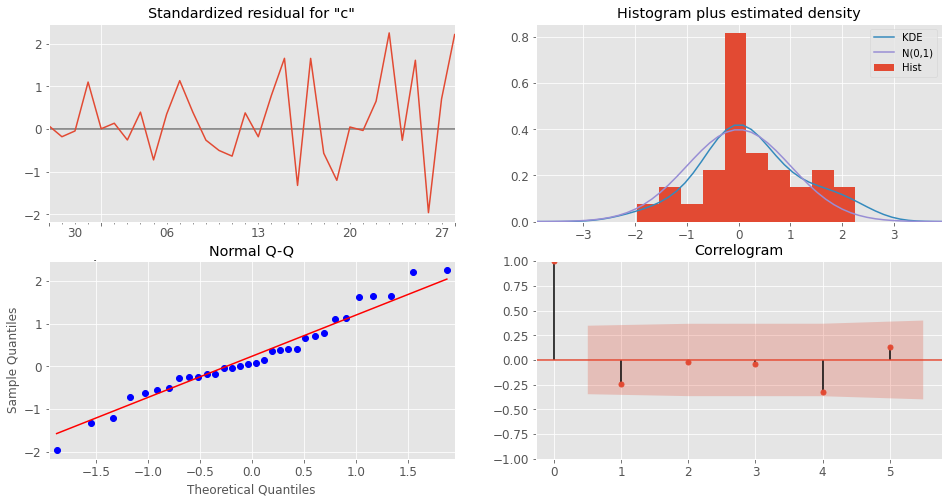

In [114]:
# Diagnóstico do modelo
modelo_sarima_fit.plot_diagnostics(lags = 5, figsize = (16,8))
plt.show()

In [ ]:
test

observationdate
2020-04-29     79685.0
2020-04-30     87187.0
2020-05-01     92202.0
2020-05-02     97100.0
2020-05-03    101826.0
2020-05-04    108620.0
2020-05-05    115455.0
2020-05-06    126611.0
2020-05-07    135773.0
2020-05-08    146894.0
2020-05-09    156061.0
2020-05-10    162699.0
2020-05-11    169594.0
2020-05-12    178214.0
2020-05-13    190137.0
2020-05-14    203165.0
2020-05-15    220291.0
2020-05-16    233511.0
2020-05-17    241080.0
2020-05-18    255368.0
2020-05-19    271885.0
Freq: D, Name: confirmed, dtype: float64

In [115]:
# Previsões um passo a frente
sarima_predict = modelo_sarima_fit.get_prediction(start = pd.to_datetime('2020-04-29'), 
                                                       end = pd.to_datetime('2020-05-19'),
                                                       dynamic = False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



In [116]:
# Intervalo de confiança
sarima_predict_i_conf = sarima_predict.conf_int()
sarima_predict_i_conf

,lower confirmed,upper confirmed
2020-04-29,77632.379585,80339.921514
2020-04-30,82171.920637,88209.712766
2020-05-01,86328.611293,96412.326145
2020-05-02,90224.848074,104964.756202
2020-05-03,93734.093267,113670.139889
2020-05-04,97165.033920,122786.581697
2020-05-05,100059.920219,131817.755076
2020-05-06,102881.647065,141195.873315
2020-05-07,105981.360860,151246.915613
2020-05-08,109035.452267,161626.138552


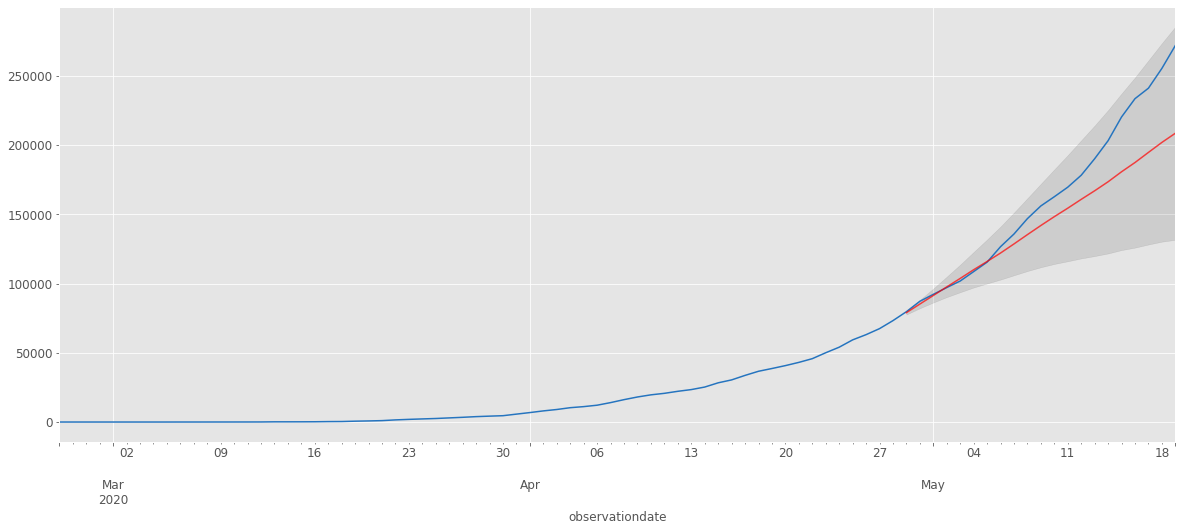

In [121]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados da série óleo combustível
ax = confirmados.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (1, 1, 0)x(0, 1, 1, 30)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_i_conf.index,
                # lower (menores valores previstos)
                sarima_predict_i_conf.iloc[:, 0],
                # upper (maiores valores previstos)
                sarima_predict_i_conf.iloc[:, 1], color = 'k', alpha = 0.1)

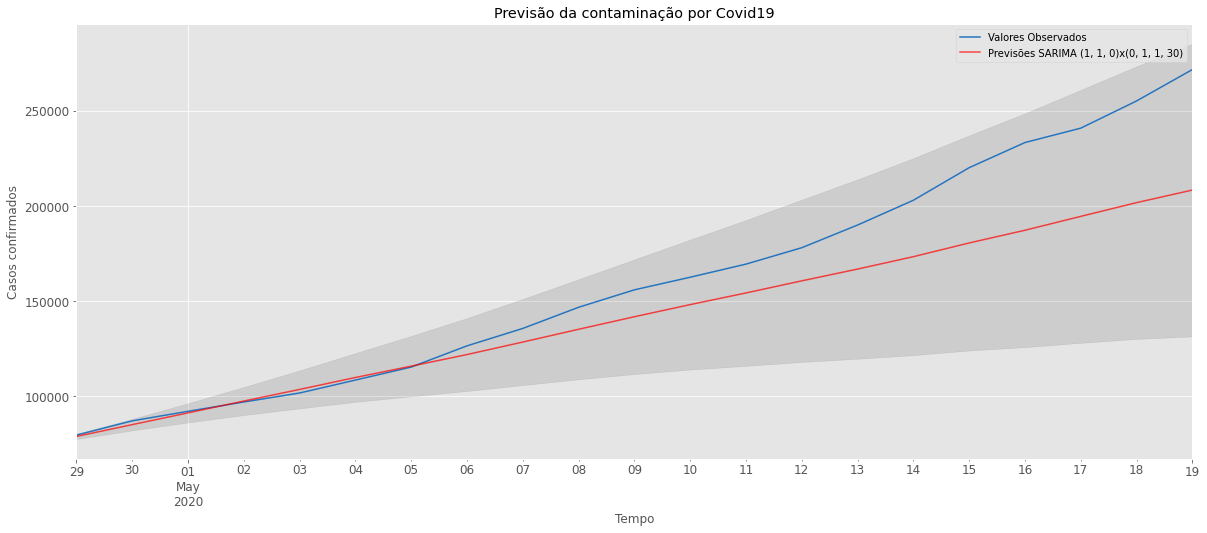

In [138]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados da série óleo combustível
ax = confirmados.iloc[63:].plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (1, 1, 0)x(0, 1, 1, 30)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_i_conf.index,
                # lower (menores valores previstos)
                sarima_predict_i_conf.iloc[:, 0],
                # upper (maiores valores previstos)
                sarima_predict_i_conf.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão da contaminação por Covid19')
plt.xlabel('Tempo')
plt.ylabel('Casos confirmados')
plt.legend()
plt.show()

In [124]:
# Função para visualização das métricas mse, rmse e mape
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

In [125]:
# Calculando a performance do modelo
sarima_resultados = performance(test, sarima_predict.predicted_mean)
sarima_resultados

MSE das previsões é 727974954.85
RMSE das previsões é 26981.01
MAPE das previsões é 9.02


#Prophet

In [ ]:
confirmados

observationdate
2020-02-26         1.0
2020-02-27         1.0
2020-02-28         1.0
2020-02-29         2.0
2020-03-01         2.0
                ...   
2020-05-15    220291.0
2020-05-16    233511.0
2020-05-17    241080.0
2020-05-18    255368.0
2020-05-19    271885.0
Freq: D, Name: confirmed, Length: 84, dtype: float64

In [ ]:
confirmados

observationdate
2020-02-26         1.0
2020-02-27         1.0
2020-02-28         1.0
2020-02-29         2.0
2020-03-01         2.0
                ...   
2020-05-15    220291.0
2020-05-16    233511.0
2020-05-17    241080.0
2020-05-18    255368.0
2020-05-19    271885.0
Freq: D, Name: confirmed, Length: 84, dtype: float64

##O modelo Prophet foi aplicado com termos aditivos em primeiro momento e em seguida com termos multiplicativos. O segundo caso baixou o valor da raiz do erro médio quadrádico, porém o modelo não se comportou muito bem para esse conjunto de dados.

In [128]:
# Criando dataframes para dados de treino e teste
df_treino = pd.DataFrame({'observationdate':train.index, 'confirmed':train.values})
df_teste = pd.DataFrame({'observationdate':test.index, 'confirmed':test.values})

In [129]:
# Renomeando as colunas, pois o Prophet exige os nomes, 'ds' e 'y'. 
df_treino = df_treino.rename(columns = {'observationdate': 'ds', 'confirmed': 'y'})
df_teste = df_teste.rename(columns = {'observationdate': 'ds', 'confirmed': 'y'})

In [130]:
# Cria o modelo Prophet com sazonalidade anual e define o intervalo de confiança
# O valor de 0.95 indica que espera-se ver no futuro uma tendência quase similar à tendência atual
modelo_prophet = Prophet(interval_width = 0.95, daily_seasonality = True)

In [131]:
# Treinamento do modelo
modelo_prophet.fit(df_treino)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd68cbm1t/_clrf6ea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd68cbm1t/c9h5a7pj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63120', 'data', 'file=/tmp/tmpd68cbm1t/_clrf6ea.json', 'init=/tmp/tmpd68cbm1t/c9h5a7pj.json', 'output', 'file=/tmp/tmpxsy_rm68/prophet_model-20221001154956.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:49:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [132]:
# Dataset para as previsões
dataset_para_previsoes = modelo_prophet.make_future_dataframe(periods = 100, freq = 'D')
dataset_para_previsoes.count()

ds    163
dtype: int64

In [133]:
# Forecast (Previsões futuras)
forecast_modelo_prophet = modelo_prophet.predict(dataset_para_previsoes)

In [134]:
# Previsões feitas pelo modelo
forecast_modelo_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-02-26,-404.920063,-2328.113498,1663.404314
1,2020-02-27,-324.476815,-2383.887105,1671.230583
2,2020-02-28,-207.986381,-2149.167419,1762.844852
3,2020-02-29,0.854924,-1992.064898,2045.397619
4,2020-03-01,-90.539550,-2129.576708,2050.295150


In [135]:
# As previsões do Prophet 
forecast_modelo_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-26,-14.246112,-2328.113498,1663.404314,-14.246112,-14.246112,-390.673951,-390.673951,-390.673951,-229.203287,-229.203287,-229.203287,-161.470665,-161.470665,-161.470665,0.0,0.0,0.0,-404.920063
1,2020-02-27,15.914778,-2383.887105,1671.230583,15.914778,15.914778,-340.391593,-340.391593,-340.391593,-229.203287,-229.203287,-229.203287,-111.188306,-111.188306,-111.188306,0.0,0.0,0.0,-324.476815
2,2020-02-28,46.075668,-2149.167419,1762.844852,46.075668,46.075668,-254.062049,-254.062049,-254.062049,-229.203287,-229.203287,-229.203287,-24.858762,-24.858762,-24.858762,0.0,0.0,0.0,-207.986381
3,2020-02-29,76.236557,-1992.064898,2045.397619,76.236557,76.236557,-75.381633,-75.381633,-75.381633,-229.203287,-229.203287,-229.203287,153.821653,153.821653,153.821653,0.0,0.0,0.0,0.854924
4,2020-03-01,106.397446,-2129.576708,2050.295150,106.397446,106.397446,-196.936996,-196.936996,-196.936996,-229.203287,-229.203287,-229.203287,32.266291,32.266291,32.266291,0.0,0.0,0.0,-90.539550


In [ ]:
test.shape, train.shape

((21,), (63,))

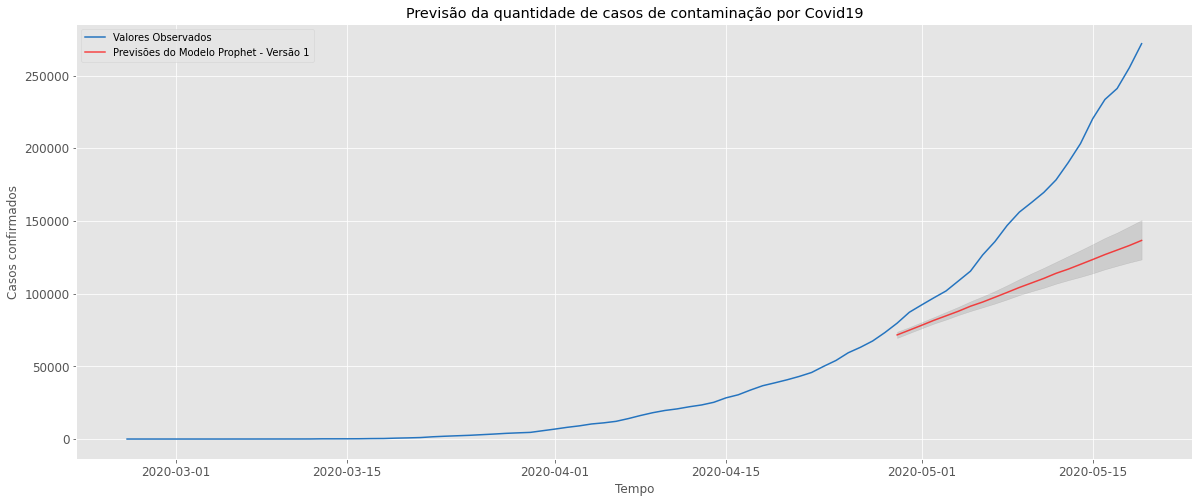

In [137]:
# Plot

# Série original
plt.plot(confirmados.index,
         confirmados.values,
         label = 'Valores Observados',
         color = '#2574BF')

# Previsões
plt.plot(confirmados[63:84].index, 
         forecast_modelo_prophet[63:84]['yhat'].values,
         label = 'Previsões do Modelo Prophet - Versão 1', 
         alpha = 0.7, 
         color = 'red')

# Limites de Confiança
plt.fill_between(confirmados[63:84].index,
                 forecast_modelo_prophet[63:84]['yhat_lower'].values,
                 forecast_modelo_prophet[63:84]['yhat_upper'].values, 
                 color = 'k', 
                 alpha = 0.1)

plt.title('Previsão da quantidade de casos de contaminação por Covid19')
plt.xlabel('Tempo')
plt.ylabel('Casos confirmados')
plt.legend()
plt.show()

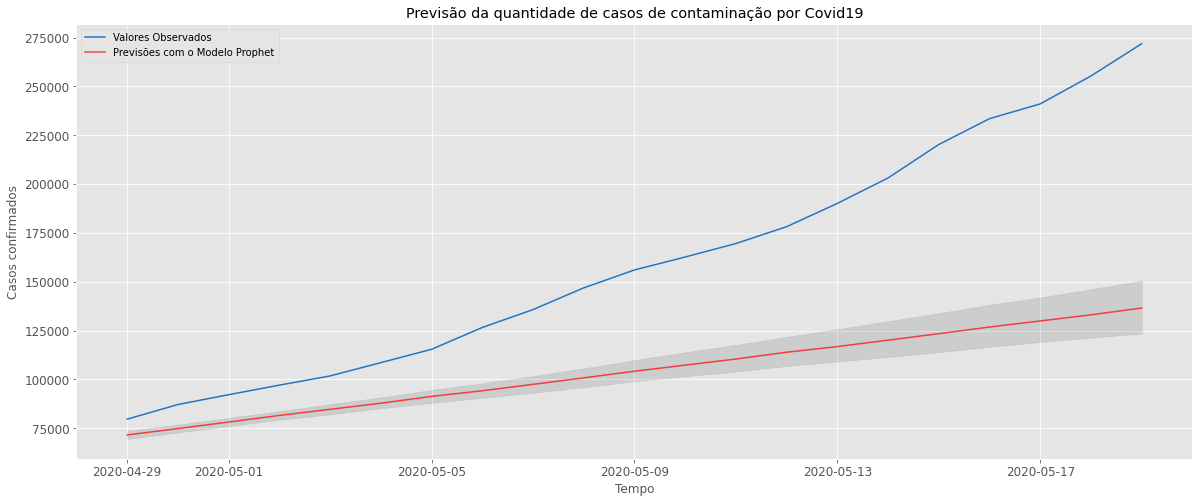

In [139]:
# Plot

# Série original
plt.plot(confirmados.iloc[63:84].index, 
         confirmados.iloc[63:84].values,
         label = 'Valores Observados',
         color = '#2574BF')

# Previsões
plt.plot(confirmados[63:84].index, 
         forecast_modelo_prophet[63:84]['yhat'].values,
         label = 'Previsões com o Modelo Prophet', 
         alpha = 0.7, 
         color = 'red')

# Limites de Confiança
plt.fill_between(confirmados[63:84].index,
                 forecast_modelo_prophet[63:84]['yhat_lower'].values,
                 forecast_modelo_prophet[63:84]['yhat_upper'].values, 
                 color = 'k', 
                 alpha = 0.1)

plt.title('Previsão da quantidade de casos de contaminação por Covid19')
plt.xlabel('Tempo')
plt.ylabel('Casos confirmados')
plt.legend()
plt.show()

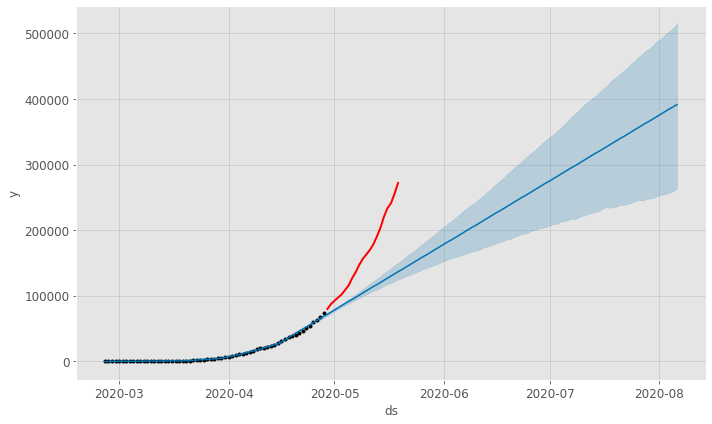

In [ ]:
# Conferindo as previsões

# Plot das previsões
fig = modelo_prophet.plot(forecast_modelo_prophet)

# Dados de Teste em vermelho
plt.plot(test, label = 'Teste', color = 'red', linewidth = 2)
plt.show()

In [ ]:
# Calculando a performance 
prophet_resultados = performance(test.values, forecast_modelo_prophet[63:84]['yhat'])
prophet_resultados

MSE das previsões é 4694871498.17
RMSE das previsões é 68519.13
MAPE das previsões é 30.87


#Prophet com sazonalidade multiplicativa

In [140]:
modelo_prophet = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=True)

In [141]:
# Treinamento do modelo
modelo_prophet.fit(df_treino)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd68cbm1t/7nw0d0i7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd68cbm1t/6vc4qc6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51476', 'data', 'file=/tmp/tmpd68cbm1t/7nw0d0i7.json', 'init=/tmp/tmpd68cbm1t/6vc4qc6n.json', 'output', 'file=/tmp/tmpiak5rhbe/prophet_model-20221001155255.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:52:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [142]:
# Dataset para as previsões
dataset_para_previsoes = modelo_prophet.make_future_dataframe(periods = 100, freq = 'D')
dataset_para_previsoes.count()

ds    163
dtype: int64

In [143]:
# Forecast (Previsões futuras)
forecast_modelo_prophet = modelo_prophet.predict(dataset_para_previsoes)

In [144]:
# Previsões feitas pelo modelo
forecast_modelo_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-02-26,-12.687695,-1364.957246,1273.035674
1,2020-02-27,-10.294585,-1289.945378,1204.401712
2,2020-02-28,-7.901475,-1221.264826,1362.435118
3,2020-02-29,-5.508352,-1275.149167,1266.984819
4,2020-03-01,-3.115230,-1336.304600,1298.070220


In [145]:
# As previsões do Prophet 
forecast_modelo_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-02-26,-0.423512,-1364.957246,1273.035674,-0.423512,-0.423512,28.95828,28.95828,28.95828,28.95828,28.95828,28.95828,0.0,0.0,0.0,-12.687695
1,2020-02-27,-0.343631,-1289.945378,1204.401712,-0.343631,-0.343631,28.95828,28.95828,28.95828,28.95828,28.95828,28.95828,0.0,0.0,0.0,-10.294585
2,2020-02-28,-0.263749,-1221.264826,1362.435118,-0.263749,-0.263749,28.95828,28.95828,28.95828,28.95828,28.95828,28.95828,0.0,0.0,0.0,-7.901475
3,2020-02-29,-0.183867,-1275.149167,1266.984819,-0.183867,-0.183867,28.95828,28.95828,28.95828,28.95828,28.95828,28.95828,0.0,0.0,0.0,-5.508352
4,2020-03-01,-0.103986,-1336.304600,1298.070220,-0.103986,-0.103986,28.95828,28.95828,28.95828,28.95828,28.95828,28.95828,0.0,0.0,0.0,-3.115230


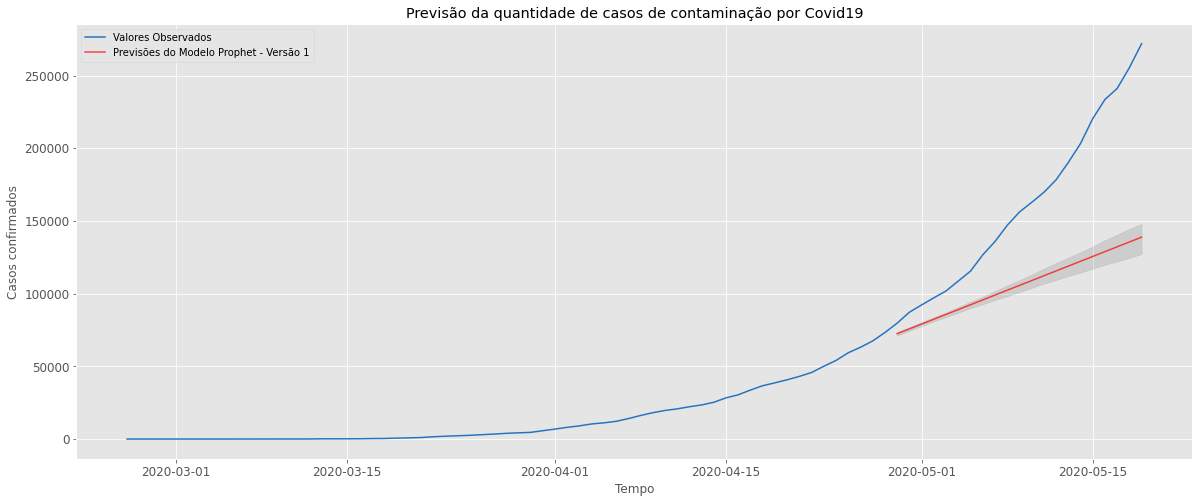

In [146]:
# Plot

# Série original
plt.plot(confirmados.index, 
         confirmados.values,
         label = 'Valores Observados',
         color = '#2574BF')

# Previsões
plt.plot(confirmados[63:84].index, 
         forecast_modelo_prophet[63:84]['yhat'].values,
         label = 'Previsões do Modelo Prophet - Versão 1', 
         alpha = 0.7, 
         color = 'red')

# Limites de Confiança
plt.fill_between(confirmados[63:84].index,
                 forecast_modelo_prophet[63:84]['yhat_lower'].values,
                 forecast_modelo_prophet[63:84]['yhat_upper'].values, 
                 color = 'k', 
                 alpha = 0.1)

plt.title('Previsão da quantidade de casos de contaminação por Covid19')
plt.xlabel('Tempo')
plt.ylabel('Casos confirmados')
plt.legend()
plt.show()

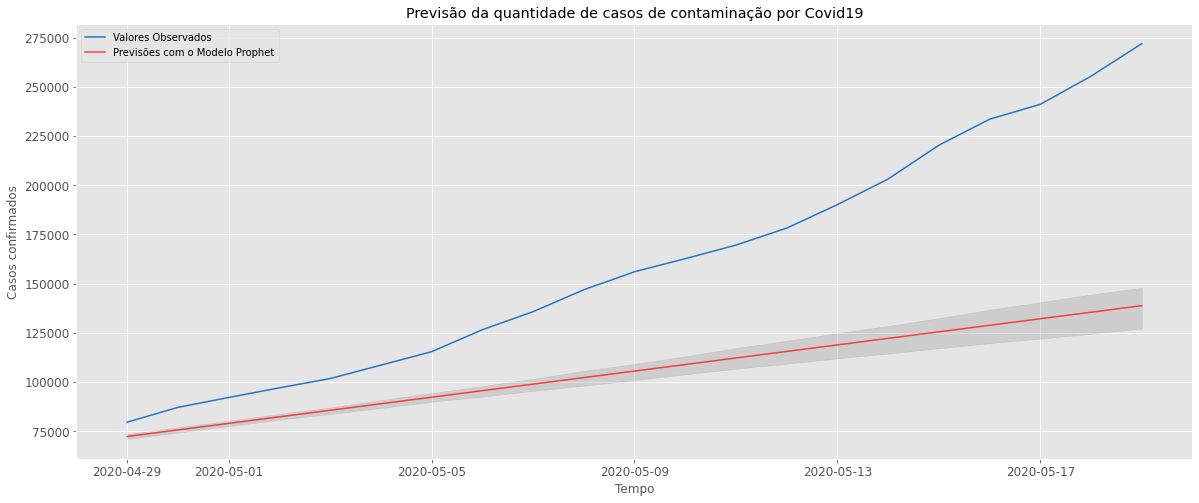

In [147]:
# Plot

# Série original
plt.plot(confirmados.iloc[63:84].index, 
         confirmados.iloc[63:84].values,
         label = 'Valores Observados',
         color = '#2574BF')

# Previsões
plt.plot(confirmados[63:84].index, 
         forecast_modelo_prophet[63:84]['yhat'].values,
         label = 'Previsões com o Modelo Prophet', 
         alpha = 0.7, 
         color = 'red')

# Limites de Confiança
plt.fill_between(confirmados[63:84].index,
                 forecast_modelo_prophet[63:84]['yhat_lower'].values,
                 forecast_modelo_prophet[63:84]['yhat_upper'].values, 
                 color = 'k', 
                 alpha = 0.1)

plt.title('Previsão da quantidade de casos de contaminação por Covid19')
plt.xlabel('Tempo')
plt.ylabel('Casos confirmados')
plt.legend()
plt.show()


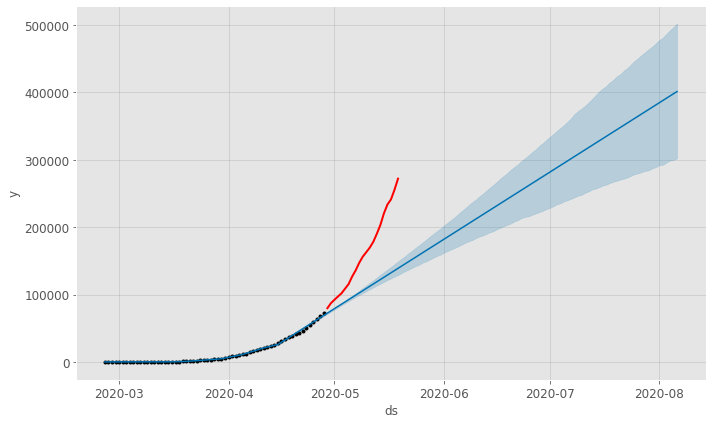

In [ ]:
# Conferindo as previsões

# Plot das previsões
fig = modelo_prophet.plot(forecast_modelo_prophet)

# Dados de Teste em vermelho
plt.plot(test, label = 'Teste', color = 'red', linewidth = 2)
plt.show()

In [ ]:
# Calculando a performance 
prophet_resultados = performance(test.values, forecast_modelo_prophet[63:84]['yhat'])
prophet_resultados

MSE das previsões é 4484100665.4
RMSE das previsões é 66963.43
MAPE das previsões é 29.9


#DeepAr

##Aplicação da rede neural recorrente DeepAr

In [ ]:
# Instala o pacote mxnet
!pip install -q mxnet
# Instala o pacote gluonts
!pip install -q gluonts
# MxNet / GluonTS
#import mxnet
import gluonts
from mxnet import gpu, cpu
from mxnet.context import num_gpus
from gluonts.dataset.common import ListDataset
from gluonts.mx.trainer import Trainer

#from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
#from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=9d33450dfbb1bf19f90de7f87a353afa52de53497c1fefdd8b522ea16db23a5d
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Transfromando os dados em um dataframe pandas
X = pd.DataFrame(confirmados)

In [ ]:
#Divisão em 75% dos dados para treino e 25% para teste
treino = X[:-21]
teste = X[0:]

In [ ]:
treino.shape, teste.shape

((63, 1), (84, 1))

In [ ]:
#Função Para Plotar o Forecast

def plot_forecast(predictor, test_data):
    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
        to_pandas(test_entry).plot(linewidth = 2)
        forecast.plot(color = 'g', prediction_intervals = [80.0, 95.0])
    plt.grid(which = 'both')

In [ ]:
# Dataset de treino para o GluonTS
training_data = ListDataset([{"start": treino.index[0], 
                              "target": treino.confirmed[:"2020-04-29"]}], 
                            freq = "D")

In [ ]:
teste

,confirmed
observationdate,
2020-02-26,1.0
2020-02-27,1.0
2020-02-28,1.0
2020-02-29,2.0
2020-03-01,2.0
...,...
2020-05-15,220291.0
2020-05-16,233511.0
2020-05-17,241080.0


In [ ]:
# Dataset de teste para o GluonTS
test_data = ListDataset([{"start": teste.index[0], 
                           "target": teste.confirmed}], 
                        freq = "D")

#Criando o Modelo:

modelo_gluonts = DeepAREstimator(freq = "D", 
                                 prediction_length =21,
                                 context_length=21, 
                                 distr_output = gluonts.mx.distribution.student_t.StudentTOutput(),
                                 num_layers = 3,
                                 num_cells = 40,
                                 dropout_rate=0.002,
                                  trainer = Trainer(learning_rate = 6e-2, 
                                                   epochs = 10,
                                                   num_batches_per_epoch = 32))

In [ ]:
#Criando o Modelo:

modelo_gluonts = DeepAREstimator(freq = "D", 
                                 prediction_length =21,
                                 context_length=21, 
                                 distr_output = gluonts.mx.distribution.student_t.StudentTOutput(),
                                 num_layers = 3,
                                 num_cells = 40,
                                 dropout_rate=0.002,
                                  trainer = Trainer(learning_rate = 6e-2, 
                                                   epochs = 10,
                                                   num_batches_per_epoch = 32))

In [ ]:
#  Fazendo o treinamento do modelo
modelo_gluonts_predictor = modelo_gluonts.train(training_data = training_data)

100%|██████████| 32/32 [00:04<00:00,  7.01it/s, epoch=10/10, avg_epoch_loss=5.82]


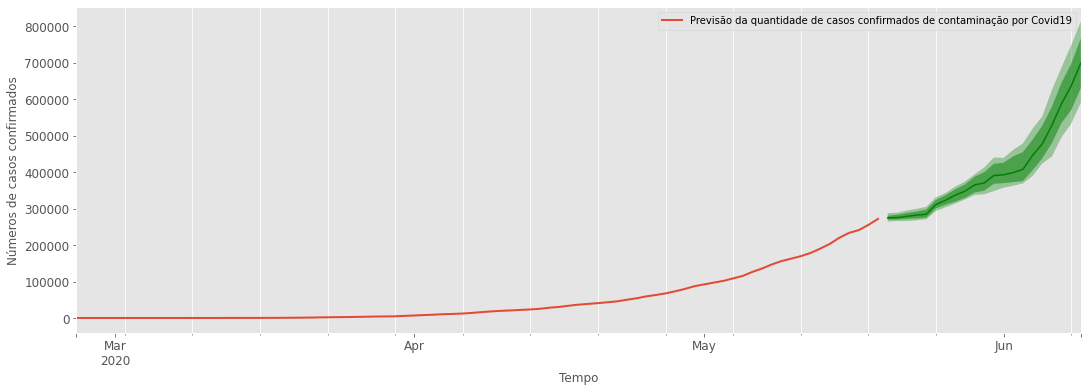

In [ ]:
# Plotando o forecast
plt.rcParams["figure.figsize"] = (18, 6)
plot_forecast(predictor = modelo_gluonts_predictor, test_data = test_data)
plt.xlabel('Tempo')
plt.ylabel("Números de casos confirmados")
plt.legend(['Previsão da quantidade de casos confirmados de contaminação por Covid19'])
plt.show()

In [ ]:
# Previsões com os dados de teste
forecast_it, ts_it = make_evaluation_predictions(dataset = test_data, 
                                                 predictor = modelo_gluonts_predictor, 
                                                 num_samples = 21)

In [ ]:
# Métricas do modelo 
metricas_agregadas, metricas_item = Evaluator()(ts_it, forecast_it, num_series = len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


In [ ]:
# Visualização das métricas
metricas_agregadas
plt.savefig('Performace do modelo DeepAR.png')
metricas_agregadas

{'MSE': 162695204.57142857,
 'abs_error': 226201.5,
 'abs_target_sum': 3373358.0,
 'abs_target_mean': 160636.09523809524,
 'seasonal_error': 1181.1935483870968,
 'MASE': 9.119165961165578,
 'MAPE': 0.06570447058904738,
 'sMAPE': 0.06351569720676967,
 'MSIS': 87.15012607987182,
 'QuantileLoss[0.1]': 176346.70625,
 'Coverage[0.1]': 0.8095238095238095,
 'QuantileLoss[0.2]': 219526.36250000002,
 'Coverage[0.2]': 0.8571428571428571,
 'QuantileLoss[0.3]': 240499.9171875,
 'Coverage[0.3]': 0.9047619047619048,
 'QuantileLoss[0.4]': 240347.89375,
 'Coverage[0.4]': 0.9047619047619048,
 'QuantileLoss[0.5]': 226201.5,
 'Coverage[0.5]': 0.9047619047619048,
 'QuantileLoss[0.6]': 208349.62500000003,
 'Coverage[0.6]': 0.9047619047619048,
 'QuantileLoss[0.7]': 174163.4421875,
 'Coverage[0.7]': 0.9047619047619048,
 'QuantileLoss[0.8]': 136174.52499999997,
 'Coverage[0.8]': 0.9047619047619048,
 'QuantileLoss[0.9]': 88467.5484375,
 'Coverage[0.9]': 0.9523809523809523,
 'RMSE': 12755.203039208296,
 'NRMSE'

<Figure size 1296x432 with 0 Axes>